In [1]:
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('..')

In [2]:
# load file name
train_img_path = '../data/train/original/'
train_label_path = '../data/train/ground_truth/'
test_img_path = '../data/test/original/'
test_label_path = '../data/test/ground_truth/'

train_img_files = os.listdir(train_img_path)
train_label_files = os.listdir(train_label_path)
test_img_files = os.listdir(test_img_path)
test_label_files = os.listdir(test_label_path)

train_img = [os.path.join(train_img_path, file) for file in train_img_files]
train_label = [os.path.join(train_label_path, file) for file in train_label_files]
test_img = [os.path.join(test_img_path, file) for file in test_img_files]
test_label = [os.path.join(test_label_path, file) for file in test_label_files]

print(f'Number of training images: {len(train_img)}')
print(f'Number of training labels: {len(train_label)}')
print(f'Number of testing images: {len(test_img)}')
print(f'Number of testing labels: {len(test_label)}')

Number of training images: 600
Number of training labels: 600
Number of testing images: 200
Number of testing labels: 200


In [3]:
# Utils
from PIL import Image 

def load_img(file_path):
    return Image.open(file_path)

def load_label(file_path):
    # In grayscale (1 canal)
    return Image.open(file_path).convert('L')

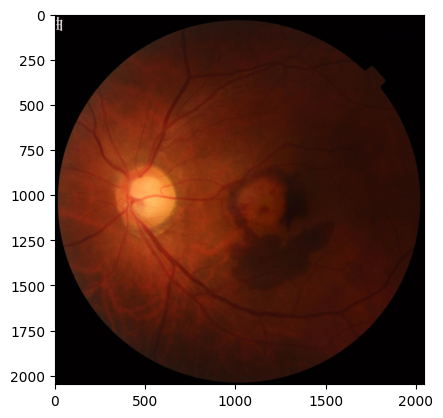

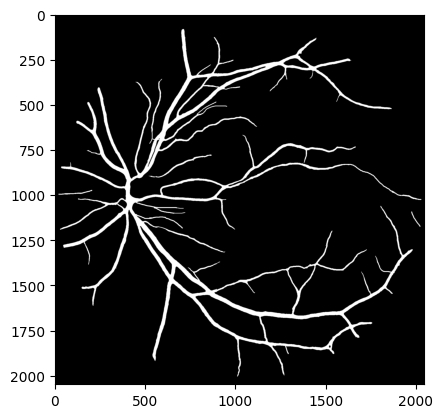

In [ ]:
# Une image et son label
num_obs = 0

img = load_img(train_img[num_obs])
plt.imshow(img)
plt.show()

label = load_label(train_label[num_obs])
plt.imshow(label)
plt.show()

In [5]:
import torchvision.transforms as transforms
from src.dataset.dataset import VesselDataset
from torch.utils.data import DataLoader, random_split

batch_size = 8

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # (3, 256, 256)
])

dataset = VesselDataset(train_img, train_label, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = VesselDataset(test_img, test_label, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
from src.models.models import UNet
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3,1).to(device)

EPOCHS = 15
LR = 0.0001
PATIENCE = 5
epsilon = 0.5
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dir_save = '../saved_models/'

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [7]:
from src.models.train import train

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS, PATIENCE, epsilon, dir_save)

100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


Epoch 1/15 | Train: 0.5221 | Val: 0.4454


100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


Epoch 2/15 | Train: 0.4235 | Val: 0.4229


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Epoch 3/15 | Train: 0.3922 | Val: 0.5390


100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


Epoch 4/15 | Train: 0.3520 | Val: 0.3220


100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Epoch 5/15 | Train: 0.3227 | Val: 0.3219


100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


Epoch 6/15 | Train: 0.2967 | Val: 0.2824


100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


Epoch 7/15 | Train: 0.2742 | Val: 0.2674


100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


Epoch 8/15 | Train: 0.2547 | Val: 0.2442


100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


Epoch 9/15 | Train: 0.2368 | Val: 0.2258


100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


Epoch 10/15 | Train: 0.2205 | Val: 0.2139


100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


Epoch 11/15 | Train: 0.2064 | Val: 0.2009


100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


Epoch 12/15 | Train: 0.1937 | Val: 0.1906


100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


Epoch 13/15 | Train: 0.1824 | Val: 0.1751


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Epoch 14/15 | Train: 0.1725 | Val: 0.1705


100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


Epoch 15/15 | Train: 0.1637 | Val: 0.1644


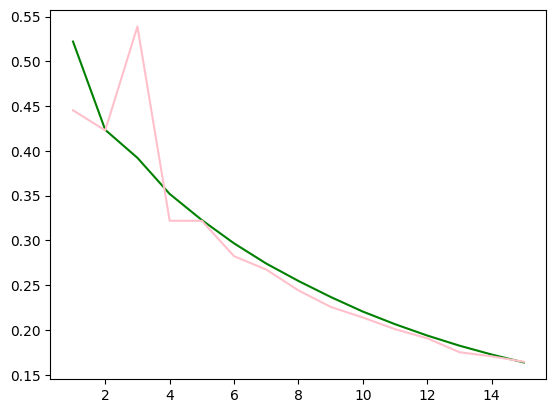

In [8]:
from src.utils.viz import viz_train_and_val_losses

viz_train_and_val_losses(train_losses, val_losses)

In [8]:
nb_images_to_test = 200

mini_test_dataset = VesselDataset(test_img[:nb_images_to_test], test_label[:nb_images_to_test], transform=transform)
mini_test_loader = DataLoader(mini_test_dataset, batch_size=1, shuffle=False)

In [9]:
# Chargement du modèle sauvegardé
import torch
from src.models.models import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3,1).to(device)

path = "../saved_models/train_20260202-141458/best_model.pth"
state_dict = torch.load(path, map_location=device)
model.load_state_dict(state_dict)

from src.models.predict import predict
preds = predict(model, mini_test_loader, device)

100%|██████████| 200/200 [00:37<00:00,  5.27it/s]


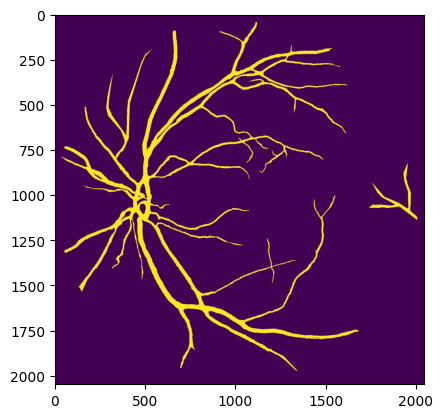

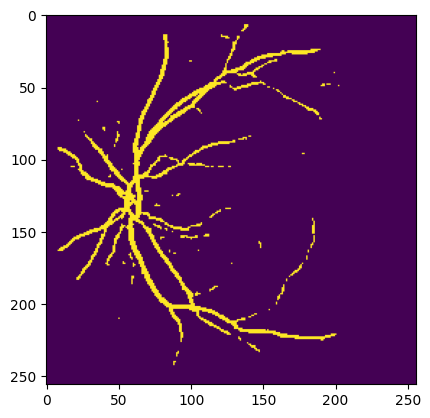

In [15]:
truth = load_label(test_label[0])
plt.imshow(truth)
plt.show()

pred = preds[0].to('cpu').squeeze().detach().numpy()
plt.imshow(pred)
plt.show()